# Combine all the data into once dataset

Once you've run the following notebooks,
- 01_stt_pecha_tools.ipynb
- 02_prodigy.ipynb

You get the following tsv files
- 01_stt_pecha_tools.tsv
- 02_prodigy.tsv

Concatenate the tsv files and clean the data

In [1]:
stt_pecha_tools = "01_stt_pecha_tools.csv"
prodigy =         "02_prodigy_finalised.csv"

In [2]:
import pandas as pd
pecha_tools_df = pd.read_csv(stt_pecha_tools)
prodigy_df = pd.read_csv(prodigy)

In [3]:
prodigy_df = prodigy_df.rename(columns={'id': 'file_name', 'transcript':'uni'})

In [4]:
df = pd.concat([pecha_tools_df, prodigy_df], ignore_index=True)

In [5]:
bad_apples = pd.read_csv('04_bad_apples.csv')

In [6]:
df = df[~df['file_name'].isin(bad_apples['file_name'])]

Drop duplicates, duplicates were introduced from prodigy annotation tool. One of the reason we had to move away from it.

In [7]:
df.drop_duplicates(subset='file_name', keep="first", inplace=True)

### clean the combined tsv

Remove unwanted characters and remove transcriptions with english characters

In [103]:
import re
def clean_transcription(text):
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    text = text.strip()
    
    text = re.sub("༌", "་",text) # there are two type of 'tsak' let's normalize 0xf0b to 0xf0c
    
    text = re.sub("༎", "།",text) # normalize double 'shae' 0xf0e to 0xf0d
    text = re.sub("༔", "།",text)
    text = re.sub("༏", "།",text)
    text = re.sub("༐", "།",text)

    text = re.sub("ཽ", "ོ",text) # normalize
    text = re.sub("ཻ", "ེ",text) # normalize "᫥"
    
    text = re.sub(r"\s+།", "།", text)
    text = re.sub(r"།+", "།", text)
    text = re.sub(r"།", "། ", text)
    text = re.sub(r"\s+་", "་", text)
    text = re.sub(r"་+", "་", text)
    text = re.sub(r"\s+", " ", text)
    
    text = re.sub(r"ཧཧཧ+", "ཧཧཧ", text)
    text = re.sub(r'ཧི་ཧི་(ཧི་)+', r'ཧི་ཧི་ཧི་', text)
    text = re.sub(r'ཧེ་ཧེ་(ཧེ་)+', r'ཧེ་ཧེ་ཧེ་', text)
    text = re.sub(r'ཧ་ཧ་(ཧ་)+', r'ཧ་ཧ་ཧ་', text)
    text = re.sub(r'ཧོ་ཧོ་(ཧོ་)+', r'ཧོ་ཧོ་ཧོ་', text)
    text = re.sub(r'ཨོ་ཨོ་(ཨོ་)+', r'ཨོ་ཨོ་ཨོ་', text)

    chars_to_ignore_regex = "[\,\?\.\!\-\;\:\"\“\%\‘\”\�\/\{\}\(\)༽》༼《༄༅༈༑༠'|·×༆༸༾ཿ྄྅྆྇ྋ࿒ᨵ​’„╗᩺╚༿᫥ྂ༊ྈ༁༂༃༇༈༉༒༷༺༻࿐࿑࿓࿔࿙࿚༴]"
    text = re.sub(chars_to_ignore_regex, '', text)+" "
    return text

def check_if_regex(text):
    text = str(text)
    regex = re.compile(r'[a-zA-Z]+')
    match = re.search(regex, text)
    
    return bool(match)
    
print(clean_transcription('ཧིཧོ་ཧོ་ཧོ་ཧོ་ཧོ་ཧོ་  ཧ་ ཧ་ཧ་། །  འ་༽འ་××འ༌༌༌༌༌༌༌གྲོ།ཚ ར་སོང་ངེ་། '))

ཧིཧོ་ཧོ་ཧོ་ ཧ་ ཧ་ཧ་། འ་འ་འ་གྲོ། ཚ ར་སོང་ངེ་།  


In [104]:
df = df[df['uni'].str.len() > 0]

In [105]:
df = df[~df['uni'].apply(check_if_regex)]

In [106]:
df['uni'] = df['uni'].map(clean_transcription)

In [107]:
from datasets import Dataset
common_voice_train = Dataset.from_pandas(df)

In [108]:
def extract_all_chars(batch):
    all_text = " ".join(batch["uni"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

In [109]:
vocab_train = common_voice_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_train.column_names)

Map:   0%|          | 0/787762 [00:00<?, ? examples/s]

In [110]:
vocab_list = list(set(vocab_train["vocab"][0]))

In [111]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}

In [112]:
all = ''
for c in vocab_dict:
    all += c

In [114]:
sorted(all)
print("num of unique chars:", len(all))
x=" ".join([str(i) for i in sorted(all)])
print(x)

print()

x="ཨ".join([str(i) for i in sorted(all)])
print(x)

num of unique chars: 113
  0 1 2 3 4 5 6 7 8 9 ༀ ་ ། ༡ ༢ ༣ ༤ ༥ ༦ ༧ ༨ ༩ ཀ ཁ ག གྷ ང ཅ ཆ ཇ ཉ ཊ ཋ ཌ ཌྷ ཎ ཏ ཐ ད དྷ ན པ ཕ བ བྷ མ ཙ ཚ ཛ ཝ ཞ ཟ འ ཡ ར ལ ཤ ཥ ས ཧ ཨ ཀྵ ཪ ཱ ི ཱི ུ ཱུ ཷ ེ ོ ཾ ྀ ཱྀ ྃ ྐ ྑ ྒ ྔ ྕ ྖ ྗ ྙ ྚ ྛ ྜ ྞ ྟ ྠ ྡ ྡྷ ྣ ྤ ྥ ྦ ྦྷ ྨ ྩ ྪ ྫ ྭ ྰ ྱ ྲ ླ ྴ ྵ ྶ ྷ ྸ ྻ ྼ

 ཨ0ཨ1ཨ2ཨ3ཨ4ཨ5ཨ6ཨ7ཨ8ཨ9ཨༀཨ་ཨ།ཨ༡ཨ༢ཨ༣ཨ༤ཨ༥ཨ༦ཨ༧ཨ༨ཨ༩ཨཀཨཁཨགཨགྷཨངཨཅཨཆཨཇཨཉཨཊཨཋཨཌཨཌྷཨཎཨཏཨཐཨདཨདྷཨནཨཔཨཕཨབཨབྷཨམཨཙཨཚཨཛཨཝཨཞཨཟཨའཨཡཨརཨལཨཤཨཥཨསཨཧཨཨཨཀྵཨཪཨཱཨིཨཱིཨུཨཱུཨཷཨེཨོཨཾཨྀཨཱྀཨྃཨྐཨྑཨྒཨྔཨྕཨྖཨྗཨྙཨྚཨྛཨྜཨྞཨྟཨྠཨྡཨྡྷཨྣཨྤཨྥཨྦཨྦྷཨྨཨྩཨྪཨྫཨྭཨྰཨྱཨྲཨླཨྴཨྵཨྶཨྷཨྸཨྻཨྼ


In [115]:
! pip install pyewts

### Convert unicode tibetan characters into wylie format

In [116]:
import pyewts

converter = pyewts.pyewts()

df['wylie'] = df['uni'].apply(converter.toWylie)

In [117]:
df['char_len'] = df['uni'].str.len()

In [120]:
! pip install matplotlib

<Axes: >

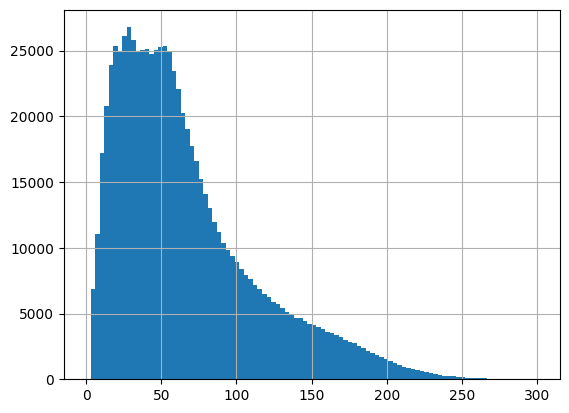

In [121]:
df['char_len'].hist(bins=100, range=(0, 300))

In [122]:
df['char_len'].describe()

count    787762.000000
mean         66.395664
std          47.109873
min           1.000000
25%          31.000000
50%          55.000000
75%          89.000000
max         394.000000
Name: char_len, dtype: float64

In [123]:
df.shape[0]

787762

In [124]:
upper_cutoff = 400
lower_cutoff = 5

In [125]:
df[df['char_len'] > upper_cutoff].shape[0], df[df['char_len'] < lower_cutoff].shape[0]

(0, 3755)

In [126]:
df[df['char_len'] > upper_cutoff][['uni', 'url', 'char_len']].sort_values(by='char_len').to_csv('04_longer_than_upper_cutoff.csv', index=False)

In [127]:
df[df['char_len'] < lower_cutoff][['uni', 'url', 'char_len']].sort_values(by='char_len').to_csv('04_shorter_than_lower_cutoff.csv', index=False)

In [128]:
df = df[(df['char_len'] < upper_cutoff) & (df['char_len'] > lower_cutoff)]

In [129]:
df.shape[0]

780901

### Get the audio time duration from the file name. 

There is to format for encoding the time span. We use the one with \_to\_ now. The difference came from the using a different library to do the Voice Activity Detection and splitting the audio for Tibetan Teachings. We have since started using pyannote-audio for all departments now.

In [130]:
def getTimeSpan(filename):

    filename = filename.replace(".wav", "")
    filename = filename.replace(".WAV", "")
    filename = filename.replace(".mp3", "")
    filename = filename.replace(".MP3", "")
    try:
        if "_to_" in filename:
            start, end = filename.split("_to_")
            start = start.split("_")[-1]
            end = end.split("_")[0]
            end = float(end)
            start = float(start)
            return abs(end - start)/1000
        else:
            start, end = filename.split("-")
            start = start.split("_")[-1]
            end = end.split("_")[0]
            end =   float(end)
            start = float(start)
            return abs(end - start)
    except Exception as err:
        print(f"filename is:'{filename}'. Could not parse to get time span.")
        return 0
    

getTimeSpan("STT_TT00031_03471.850-03477.44")

5.5900000000001455

In [131]:
df['audio_len'] = df['file_name'].apply(getTimeSpan)

In [132]:
df['audio_len'].describe()

count    780901.000000
mean          3.555775
std           2.642695
min           0.200000
25%           1.600000
50%           2.659000
75%           4.864000
max          13.650000
Name: audio_len, dtype: float64

<Axes: >

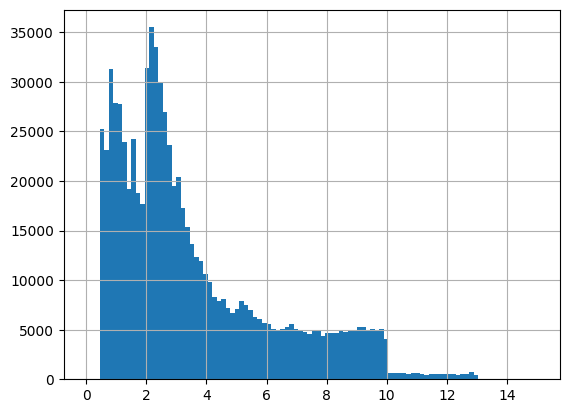

In [133]:
df['audio_len'].hist(bins=100, range=(0, 15))

In [134]:
df['url'] = 'https://d38pmlk0v88drf.cloudfront.net/wav16k/' + df['file_name'] + '.wav'

In [135]:
df['url'] = df['url'].map(lambda x : x.replace('#','%23'))

In [136]:
df = df[['file_name','uni', 'wylie', 'url', 'dept', 'grade', 'char_len',  'audio_len']]

In [137]:
df.head()

,file_name,uni,wylie,url,dept,grade,char_len,audio_len
0,STT_AB00565_0410_1675759_to_1682175,དེ་ལ་བརྟེན་ནས་མེ་དང་བུད་ཤིང་ལ་རང་བཞིན་མེད་དོ་ས...,de la brten nas me dang bud shing la rang bzhi...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_AB,2.0,75,6.416
1,STT_AB00565_0412_1692363_to_1693165,ཐལ་འགྱུར་ནི་,thal 'gyur ni _,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_AB,2.0,13,0.802
2,STT_AB00565_0415_1709513_to_1713421,ཕ་རོལ་པོ་ལ་མི་འདོད་པ་འཕེན་པ་འདི་འདྲ་རྣམས་ཡིན་པས་,pha rol po la mi 'dod pa 'phen pa 'di 'dra rna...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_AB,2.0,49,3.908
3,STT_AB00565_0416_1714087_to_1717790,དེས་མཚོན་ནས་ཐལ་བ་གཞན་རྣམས་ཀྱང་རྟོགས་པར་བྱའོ།,des mtshon nas thal ba gzhan rnams kyang rtogs...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_AB,2.0,46,3.703
5,STT_AB00565_0424_1767704_to_1769104,དཔང་པོ་རྒོལ་བ་དང་,dpang po rgol ba dang _,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_AB,2.0,18,1.400


In [138]:
df.to_csv('04_combine_all.csv', index=False)

In [139]:
! aws s3 cp 04_combine_all.csv s3://monlam.ai.stt/tsv/04_combine_all.csv

upload: ./04_combine_all.csv to s3://monlam.ai.stt/tsv/04_combine_all.csv


In [42]:
! aws s3 cp 04_bad_apples.csv s3://monlam.ai.stt/tsv/04_bad_apples.csv

upload: ./04_bad_apples.csv to s3://monlam.ai.stt/tsv/04_bad_apples.csv


In [140]:
df['uni'].str.contains('ཧཧཧ').value_counts()

uni
False    780789
True        112
Name: count, dtype: int64

In [139]:
import pandas as pd

df = pd.read_csv('04_combine_all.csv')

#### Hours in each department

In [141]:
df.groupby('dept')['audio_len'].sum()/60/60

dept
STT_AB    130.824523
STT_CS    109.235087
STT_MV     32.602046
STT_NS    191.959695
STT_PC     21.936390
STT_TT    284.750129
Name: audio_len, dtype: float64

#### Total hours

In [142]:
df['audio_len'].sum()/60/60

771.3078705555555

In [143]:
# df.sort_values(by='audio_len', ascending=False, inplace=True)
df = df.sample(frac = 1)

In [144]:
df.iloc[0:100,[0, 1, 3, 5]].to_csv("04_random_100.csv", index=False)
df.iloc[0:100,[0, 1, 3, 5]].head()

,file_name,uni,url,grade
653692,STT_TT00104_05232.850-05233.350,གོ་བ་གསར་དུ་བསྒྲུག,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,NaN
673558,STT_TT00074_01653.650-01654.300,དེ་འདྲའི་ཅིག་གི་,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,NaN
675541,STT_TT00083_3393.000-3394.000,ཨེ་ནས་དོན།,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,NaN
248207,STT_TT00524_0013_68450_to_72898,ཕྱི་ལོགས་ཀི་སྣང་བ་དེ་ཚོ་ཡང་། དེ་ནས། དཔེ་བདེ་བ་...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,3.0
506224,STT_CS-D-2014-P-D-B02-4-R-01_0063_536835_to_54...,ལྷ་མོས་ཆུ་ཁོང་ཚོར་ལབ་ཀི་རེད། འདི། ཨེ་ནས། ཁོ་,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,NaN


In [145]:
df[df['grade'] == 3].groupby('dept').size()

dept
STT_AB     27011
STT_CS     31121
STT_MV     11962
STT_NS     88753
STT_PC     20537
STT_TT    138934
dtype: int64